In [ ]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from typing import TypedDict
from langchain_core.messages import HumanMessage
import re
import os
import streamlit as st
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from concurrent.futures import ThreadPoolExecutor

In [3]:
llm_70b = ChatGroq(model="llama-3.1-70b-versatile", api_key=st.secrets["GROQ"]["GROQ_API_KEY"])
llm_8b = ChatGroq(model="llama-3.1-8b-instant", api_key=st.secrets["GROQ"]["GROQ_API_KEY"])

In [4]:
file_path = "../data/doc_triage/pdf/Manuale-Triage.pdf"

In [5]:
file_path = "../data/doc_triage/pdf/Manuale-Triage.pdf"
loader = PyPDFLoader(file_path)
pages = loader.load()[10:20]
for doc in pages:
    doc.page_content = doc.page_content.replace("Manuale regionale Triage intra-ospedaliero modello Lazio a cinque codici \n \n", "")
    doc.page_content = re.sub(r'^\d+\s*\n\s*\n', '', doc.page_content)

In [6]:
def process_pages(pages):
    import re
    for doc in pages:
        doc.page_content = doc.page_content.replace(
            "Manuale regionale Triage intra-ospedaliero modello Lazio a cinque codici \n \n", ""
        )
        doc.page_content = re.sub(r'^\d+\s*\n\s*\n', '', doc.page_content)
    return pages

# Carica le pagine del PDF
loader = PyPDFLoader(file_path)
pages = loader.load()[11:]

# Dividi le pagine in sottogruppi per ogni core
num_cores = os.cpu_count()  # Numero di core disponibili
print(f"num_cores: {num_cores}")
chunk_size = len(pages) // num_cores + (len(pages) % num_cores > 0)
print(f"chunk_size: {chunk_size}")
chunks = [pages[i:i + chunk_size] for i in range(0, len(pages), chunk_size)]

# Parallelizza il lavoro con ProcessPoolExecutor
with ThreadPoolExecutor() as executor:
    processed_chunks = list(executor.map(process_pages, chunks))

# Combina i risultati
processed_pages = [page for chunk in processed_chunks for page in chunk]

num_cores: 20
chunk_size: 20


In [7]:
# Step 1: Configura l'indice BM25 per i titoli
bm25_retriever = BM25Retriever.from_documents(
    processed_pages
    #key_field="metadata.title"  # Usa i titoli nei metadata
)
bm25_retriever.k = 2
# Step 2: Configura FAISS per i contenuti
embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(processed_pages, embedding=embedding)
similarity_retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

# Step 3: Configura un MultiRetriever
ensemble_retriever = EnsembleRetriever(retrievers=[
    bm25_retriever,
    similarity_retriever
], weights=[0.3, 0.7])

C:\Users\david\AppData\Local\Temp\ipykernel_6024\126317053.py:8: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings()


In [8]:
class Triagetate(TypedDict):
    query: str
    ensemble_retriever : EnsembleRetriever
    user_response : str
    severity : int
    question : str
    next_node : str

def start_emergency_bot(state:Triagetate):
    # Nodo di coordinamento iniziale, ritorna lo stato invariato
    return state

def log_state(node_name, state:Triagetate):
    print(f"Node '{node_name}' State: {state}")

In [14]:
def triage_evaluation(state:Triagetate):
    log_state("triage_evaluation", state)
    query = state['query']
    retrieved_docs = ensemble_retriever.invoke(query)
    retrieved_info = [doc.page_content for doc in retrieved_docs]
    prompt = prompt = f"""
    You are a highly experienced professional in emergency medicine with over 20 years of experience, specialized in Triage operations. Your task is to assess the severity of the user's situation as efficiently as possible. 

    ### Instructions:
    1. **Primary Objective:** Determine the severity of the situation and provide a rating from 1 to 5:
    - `1`: Minimal severity, no immediate danger.
    - `5`: Critical, life-threatening emergency requiring immediate action.

    2. **Use Available Information:**
    - Base your assessment primarily on the provided documents related to Triage: {retrieved_info}.
    - If the documents do not contain sufficient information, use your expert knowledge to make an informed decision.

    3. **Efficiency in Questioning:**
    - If you cannot immediately assess the severity, ask the **minimum number of questions** necessary to clarify the situation.
    - Your goal is to avoid unnecessary questions and respond as quickly as possible while maintaining accuracy.

    4. **Output Format:**
    - If you can make a decision immediately, respond with a single number (1-5) representing the severity.
    - If additional clarification is required, ask one concise and relevant question.

    ### Input:
    - User Query: "{query}"

    ### Output:
    - Either: A single number in the range 1-5 representing the severity.
    - Or: One concise and specific question to gather the necessary information.
    """
    response = llm_70b.invoke([HumanMessage(content=prompt)]).content
    # Analizza il tipo di risposta
    if response.isdigit() and int(response) in range(1, 6):
        return {"severity": int(response), 'next_node' : 'end'}  # Restituisce il numero
    else:
        return {"question": response, 'next_node' : 'new_question'}  # Restituisce la domanda
    
def ask_user_question(state: Triagetate):
    log_state("ask_user_question", state)
    user_response = state['user_response']  # Funzione per ottenere la risposta dall'utente
    state['query'] += f" {user_response}"  # Aggiorna la query con la risposta dell'utente
    return state

def should_ask(state: Triagetate):
    log_state("route_next_node", state)
    return state['next_node']  # Restituisce il nome del prossimo nodo

In [15]:
# Creazione del grafo
graph = StateGraph(Triagetate)

# Nodo iniziale per avviare i flussi paralleli
graph.add_node("start_emergency_bot", start_emergency_bot)
graph.set_entry_point("start_emergency_bot")

graph.add_node("triage_evaluation", triage_evaluation)
graph.add_edge("start_emergency_bot", "triage_evaluation")
#graph.add_edge("ask_user_question", "triage_evaluation")

graph.add_conditional_edges(
        "triage_evaluation",
        should_ask,
        {
            "new_question": "ask_user_question",
            "end": END,
        }
    )
graph.add_node("ask_user_question", ask_user_question)
#graph.set_finish_point("triage_evaluation")

# Compilazione del grafo
app = graph.compile()

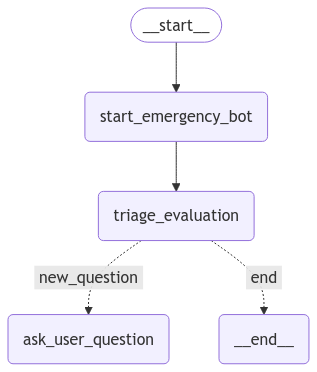

In [16]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [18]:
input_query = {
    "query": "Mi ha punto un'ape",
    "ensemble_retriever": ensemble_retriever,
    "user_response" : ""
}
for output in app.stream(input_query):
    print("Output del nodo:", output)
    if 'combine_results' in output:
        final_output = output

Output del nodo: {'start_emergency_bot': {'query': "Mi ha punto un'ape", 'ensemble_retriever': EnsembleRetriever(retrievers=[BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x000002506D92FE90>, k=2), VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002506FBFD940>, search_type='mmr', search_kwargs={'k': 3})], weights=[0.3, 0.7]), 'user_response': ''}}
Node 'triage_evaluation' State: {'query': "Mi ha punto un'ape", 'ensemble_retriever': EnsembleRetriever(retrievers=[BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x000002506D92FE90>, k=2), VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002506FBFD940>, search_type='mmr', search_kwargs={'k': 3})], weights=[0.3, 0.7]), 'user_response': ''}
Node 'route_next_node' State: {'question': 'Per valutare la severità della situazione, posso fare alcune considerazioni inizia

In [20]:
output = app.invoke(input_query)
severity = output.get('severity', None)
if severity:
    print(severity)
else:
    print(output['question'])

Node 'triage_evaluation' State: {'query': "Mi ha punto un'ape", 'ensemble_retriever': EnsembleRetriever(retrievers=[BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x000002506D92FE90>, k=2), VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002506FBFD940>, search_type='mmr', search_kwargs={'k': 3})], weights=[0.3, 0.7]), 'user_response': ''}
Node 'route_next_node' State: {'question': 'Per valutare la gravità della situazione, devo sapere alcune informazioni in più. Pertanto, la mia risposta sarà una domanda per raccogliere ulteriori dati.\n\nDomanda: "Hai avuto in passato reazioni allergiche gravi a punture di insetti, come ad esempio una reazione anafilattica?"', 'next_node': 'new_question', 'query': "Mi ha punto un'ape", 'ensemble_retriever': EnsembleRetriever(retrievers=[BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x000002506D92FE90>, k=2), VectorStoreRetriever(tags=['FAISS', 'OpenAIE